In [46]:
import pandas as pd
import os

from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scikit_posthocs as sp
from scipy.stats import f_oneway
from scipy.stats import ttest_ind_from_stats
from statsmodels.stats.anova import AnovaRM
import pingouin as pg



## Helpful functions

In [47]:
def test_normality(arr_pd, show_qq_plot=False, normality_test='kolmogorov'):
    """
    Test normality for each group in array
    """
    num_groups = arr_pd.shape[1]
    rejected_normal_groups_l = [False] * num_groups
    normality_results = []
    # Step 1 : Check normality of each interval
    for group_i in range(num_groups):
        sample = arr_pd.iloc[:, group_i].dropna().values

        if show_qq_plot:
            sm.qqplot(sample)
            plt.show()

        if normality_test == 'kolmogorov':
            norm_result = stats.kstest(sample, 'norm')
            norm_pvalue = norm_result.pvalue
        elif normality_test == 'shapiro':
            norm_result = stats.shapiro(sample)
            norm_pvalue = norm_result[1]
        else:
            raise ValueError(f'{normality_test} value error, kolmogorov or shapiro options available')
        # Reject two-sided null hypothesis (identical to norm distribution) for p < 0.05
        if norm_pvalue < 0.05:
            print(f'Interval: {arr_pd.columns[group_i]} != normal')
            rejected_normal_groups_l[group_i] = True
        else:
            print(f'Interval: {arr_pd.columns[group_i]} == normal')

        normality_results.append(norm_pvalue)
    rejected_normal_groups_np = np.array(rejected_normal_groups_l)

    return rejected_normal_groups_np, normality_results

def two_tailed_ttest(arr_pd, col1, col2, is_unpaired=True):
    if is_unpaired:
        return stats.ttest_ind(arr_pd[col1].dropna(), arr_pd[col2].dropna()).pvalue
    else:
        return stats.ttest_rel(arr_pd[col1].dropna(), arr_pd[col2].dropna()).pvalue
    

def get_stats_multiple_groups(arr_pd, show_qq_plot=False, normality_test='kolmogorov', force_parametric=False, within_group_anova=False):
    assert arr_pd.shape[1] > 2

    rejected_normal_groups_np, kstest_result = test_normality(arr_pd, show_qq_plot=show_qq_plot, normality_test=normality_test)

    stat_result = None

    arr_pd_melt = pd.melt(arr_pd, var_name='interval', value_name='value').dropna()
    # Case: Some or all intervals are NOT normal:
    # We may choose to force parametric approach anyways
    if np.sum(rejected_normal_groups_np) > 0 and (not force_parametric):
        print('Non-normal groups -> Kruskal')
        # use kruskal-wallis

        #x = [arr_pd.iloc[:, i].dropna() for i in range(arr_pd.shape[1])]
        #print(stats.kruskal(*x))
        kruskal_result = stats.kruskal(*[group['value'].values for name, group in arr_pd_melt.groupby("interval")])
        print(kruskal_result)

        # On rejection apply post-hoc Dunn w\ bonferroni p adjustment correction
        if kruskal_result.pvalue < 0.05:
            print('Rejection: kruskal')
            post_hoc_result = sp.posthoc_dunn(arr_pd_melt, val_col='value', group_col='interval', p_adjust='bonferroni')
            print('Dunn-bonferroni output', post_hoc_result)
    #Case: All intervals are normal
    else:
        if force_parametric:
            print(f'Force parametric: Anova, num normal groups: {np.sum(~rejected_normal_groups_np)}/{len(rejected_normal_groups_np)}')
        else:
            print('All normal groups -> Anova')
        # Apply anova one-way
        anova_result = f_oneway(*[group['value'].values for name, group in arr_pd_melt.groupby("interval")])
        print(anova_result)

        if anova_result.pvalue < 0.05:
            print('Rejection: anova')
            # On rejection apply tukey's test
            tukey_result = pairwise_tukeyhsd(arr_pd_melt['value'], arr_pd_melt['interval'])

            #display results
            print('Tukey output', tukey_result)
    

In [52]:
base_folder = '/Users/achilleasgeorgiou/Desktop/data_output/'
show_qq_plots =True
show_qq_plots_dense = False

# Figure 1

/Users/achilleasgeorgiou/Desktop/data_output/misc/capsid_density_data.csv
     hour_1     day_10  cell_body
0  9.400000  13.700000   31.19128
1  7.800000   8.747743   41.00000
2  7.645113  23.882290   29.00000
3  7.506638  21.589300   26.90802
4  6.388628  16.303270   36.84701


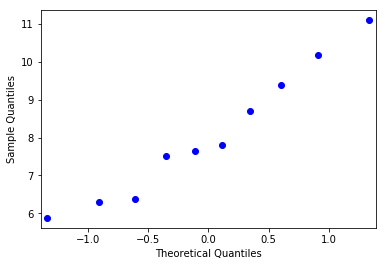

Interval: hour_1 == normal


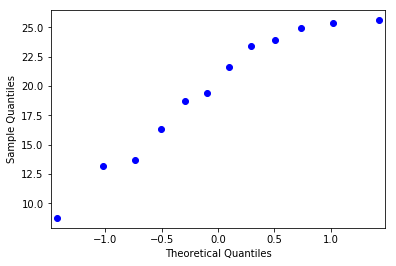

Interval: day_10 == normal


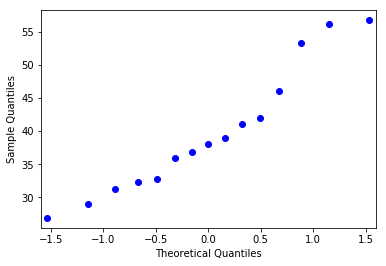

Interval: cell_body == normal
Normality p-values [0.6420902013778687, 0.23542803525924683, 0.1922445297241211]
hour_1 <-> day_10 ttest hypothesis rejected : 4.11e-06
day_10 <-> cell_body ttest hypothesis rejected: 8.14e-07


In [50]:
plot_folder = 'misc'

data_path = 'capsid_density_data.csv'

full_path = os.path.join(base_folder, plot_folder, data_path)
print(full_path)
arr_pd = pd.read_csv(full_path, index_col=0)
print(arr_pd.head())

rejected_normal_groups_np, normality_results = test_normality(arr_pd, show_qq_plot=show_qq_plots, normality_test='shapiro')

print('Normality p-values', normality_results)
# Quick check that all are normal (not rejected)
assert np.sum(rejected_normal_groups_np) == 0


# Use unpaired-t-test between groups [hour_1, day_10] (which is day_12 is paper), [day_10, cell_body]
hour_day_result = two_tailed_ttest(arr_pd, 'hour_1', 'day_10', is_unpaired=True)
day_cell_result = two_tailed_ttest(arr_pd, 'day_10', 'cell_body', is_unpaired=True)

if hour_day_result < 0.05:
    print(f'hour_1 <-> day_10 ttest hypothesis rejected : {hour_day_result:.3}')

if hour_day_result < 0.05:
    print(f'day_10 <-> cell_body ttest hypothesis rejected: {day_cell_result:.3}')

# Figure 2

## rest to run

In [53]:
plot_folder = 'dataset_1_all/all/plots'
rest_to_run_data_paths = ["rest_to_run_durations/range_30_61-step_10range_30_61-step_10-data.csv",
                            "rest_to_run_proportions/range_30_61-step_10range_30_61-step_10-data.csv",
                            "rest_to_run_sizes/range_30_61-step_10range_30_61-step_10-data.csv", 
                            "rest_to_run_speed/range_30_61-step_5range_30_61-step_5-data.csv"]

for data_path in rest_to_run_data_paths:
    full_path = os.path.join(base_folder, plot_folder, data_path)
    print(full_path)
    arr_pd = pd.read_csv(full_path, index_col=0)
    
    print(f'For plot: {data_path}')
    get_stats_multiple_groups(arr_pd, show_qq_plot=show_qq_plots_dense)

    print('------------\n\n\n\n')


/Users/achilleasgeorgiou/Desktop/data_output/dataset_1_all/all/plots/rest_to_run_durations/range_30_61-step_10range_30_61-step_10-data.csv
For plot: rest_to_run_durations/range_30_61-step_10range_30_61-step_10-data.csv
Interval: -30 != normal
Interval: -20 != normal
Interval: -10 != normal
Interval: 0 != normal
Interval: 10 != normal
Interval: 20 != normal
Interval: 30 != normal
Interval: 40 != normal
Interval: 50 != normal
Non-normal groups -> Kruskal
KruskalResult(statistic=36.498526592266735, pvalue=1.4228515672765761e-05)
Rejection: kruskal
Dunn-bonferroni output           -10       -20       -30         0        10   20        30  \
-10  1.000000  1.000000  1.000000  1.000000  1.000000  1.0  0.258258   
-20  1.000000  1.000000  1.000000  1.000000  1.000000  1.0  0.457798   
-30  1.000000  1.000000  1.000000  1.000000  1.000000  1.0  0.154906   
0    1.000000  1.000000  1.000000  1.000000  1.000000  1.0  0.513682   
10   1.000000  1.000000  1.000000  1.000000  1.000000  1.0  0.0538

## run stick run

In [54]:
plot_folder = 'dataset_1_all/all/plots'
run_stick_run_data_paths = ["run_stick_run_amplitudes/range_20_41-step_10range_20_41-step_10-data.csv",
                            "run_stick_run_durations/range_20_41-step_10range_20_41-step_10-data.csv",
                            "run_stick_run_proportions/range_20_41-step_10range_20_41-step_10-data.csv",
                            "run_stick_run_sizes/range_20_41-step_10range_20_41-step_10-data.csv",
                            "run_stick_run_speed/range_20_41-step_10range_20_41-step_10-data.csv"]

for data_path in run_stick_run_data_paths:
    full_path = os.path.join(base_folder, plot_folder, data_path)
    print(full_path)
    arr_pd = pd.read_csv(full_path, index_col=0)
    
    print(f'For plot: {data_path}')
    get_stats_multiple_groups(arr_pd, show_qq_plot=show_qq_plots_dense)

    print('------------\n\n\n\n')

/Users/achilleasgeorgiou/Desktop/data_output/dataset_1_all/all/plots/run_stick_run_amplitudes/range_20_41-step_10range_20_41-step_10-data.csv
For plot: run_stick_run_amplitudes/range_20_41-step_10range_20_41-step_10-data.csv
Interval: -20 != normal
Interval: -10 != normal
Interval: 0 != normal
Interval: 10 != normal
Interval: 20 != normal
Interval: 30 != normal
Non-normal groups -> Kruskal
KruskalResult(statistic=5.066927140759383, pvalue=0.4077670789668611)
------------




/Users/achilleasgeorgiou/Desktop/data_output/dataset_1_all/all/plots/run_stick_run_durations/range_20_41-step_10range_20_41-step_10-data.csv
For plot: run_stick_run_durations/range_20_41-step_10range_20_41-step_10-data.csv
Interval: -20 != normal
Interval: -10 != normal
Interval: 0 != normal
Interval: 10 != normal
Interval: 20 != normal
Interval: 30 != normal
Non-normal groups -> Kruskal
KruskalResult(statistic=1.3923221757091402, pvalue=0.925151298385923)
------------




/Users/achilleasgeorgiou/Desktop/data_outp

In [55]:
plot_folder = 'dataset_1_all/all/plots'
run_to_rest_data_paths = ["run_to_rest_amplitudes/range_30_61-step_10range_30_61-step_10-data.csv",
                            "run_to_rest_durations/range_30_61-step_10range_30_61-step_10-data.csv",
                            "run_to_rest_proportions/range_30_61-step_10range_30_61-step_10-data.csv",
                            "run_to_rest_sizes/range_30_61-step_10range_30_61-step_10-data.csv",
                            "run_to_rest_speed/range_30_61-step_5range_30_61-step_5-data.csv"]

for data_path in run_to_rest_data_paths:
    full_path = os.path.join(base_folder, plot_folder, data_path)
    print(full_path)
    arr_pd = pd.read_csv(full_path, index_col=0)
    
    print(f'For plot: {data_path}')
    get_stats_multiple_groups(arr_pd, show_qq_plot=show_qq_plots_dense)

    print('------------\n\n\n\n')

/Users/achilleasgeorgiou/Desktop/data_output/dataset_1_all/all/plots/run_to_rest_amplitudes/range_30_61-step_10range_30_61-step_10-data.csv
For plot: run_to_rest_amplitudes/range_30_61-step_10range_30_61-step_10-data.csv
Interval: -30 != normal
Interval: -20 != normal
Interval: -10 != normal
Interval: 0 != normal
Interval: 10 != normal
Interval: 20 != normal
Interval: 30 != normal
Interval: 40 != normal
Interval: 50 != normal
Non-normal groups -> Kruskal
KruskalResult(statistic=12.421308627409417, pvalue=0.13337274433150498)
------------




/Users/achilleasgeorgiou/Desktop/data_output/dataset_1_all/all/plots/run_to_rest_durations/range_30_61-step_10range_30_61-step_10-data.csv
For plot: run_to_rest_durations/range_30_61-step_10range_30_61-step_10-data.csv
Interval: -30 != normal
Interval: -20 != normal
Interval: -10 != normal
Interval: 0 != normal
Interval: 10 != normal
Interval: 20 != normal
Interval: 30 != normal
Interval: 40 != normal
Interval: 50 != normal
Non-normal groups -> Kru

# Figure S3

## Section C - Astrocyte density in BX layers

/Users/achilleasgeorgiou/Desktop/data_output/misc/layer_density_astrocyte_data.csv
   astro_layer_1  astro_layer_2  astro_layer_3  astro_layer_4
0            0.0       3.172428      10.812469        5.39728
1            0.0       4.650038      11.912600        2.95308
2            0.0       2.069057      15.193643        4.20275
3            0.0       6.608708      23.680269        3.80695
4            0.0       4.647070      32.186379        4.86940


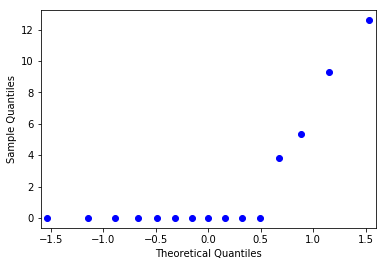

Interval: astro_layer_1 != normal


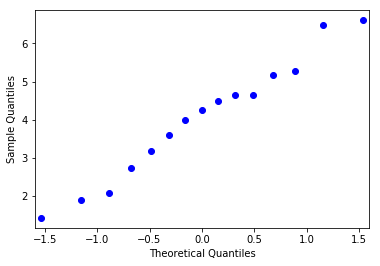

Interval: astro_layer_2 == normal


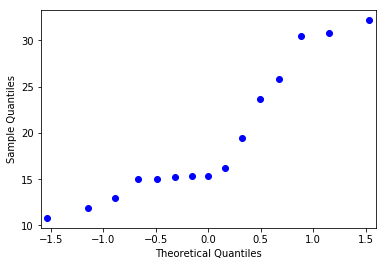

Interval: astro_layer_3 != normal


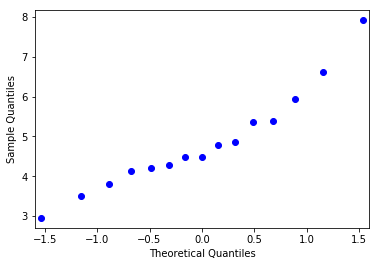

Interval: astro_layer_4 == normal
Non-normal groups -> Kruskal
KruskalResult(statistic=39.279452054794554, pvalue=1.51446897255939e-08)
Rejection: kruskal
Dunn-bonferroni output                astro_layer_1  astro_layer_2  astro_layer_3  astro_layer_4
astro_layer_1   1.000000e+00       0.536169   7.600960e-09       0.087322
astro_layer_2   5.361693e-01       1.000000   7.360686e-05       1.000000
astro_layer_3   7.600960e-09       0.000074   1.000000e+00       0.001712
astro_layer_4   8.732176e-02       1.000000   1.712104e-03       1.000000


In [56]:
plot_folder = 'misc'

data_path = 'layer_density_astrocyte_data.csv'
full_path = os.path.join(base_folder, plot_folder, data_path)
print(full_path)

arr_pd = pd.read_csv(full_path, index_col=0)
print(arr_pd.head())

get_stats_multiple_groups(arr_pd, show_qq_plot=show_qq_plots, normality_test='shapiro')

## Section F - Neuron density in BX layers

   axon_layer_1  axon_layer_2  axon_layer_3  axon_layer_4
0      0.000000      0.000000      5.241551      8.727168
1      0.000000      0.683069      5.181616      6.143110
2      0.000000      0.487914      4.472532      4.601446
3     10.381305      2.476657     16.368975     10.039829
4      0.000000      0.921493     14.150535      7.966867


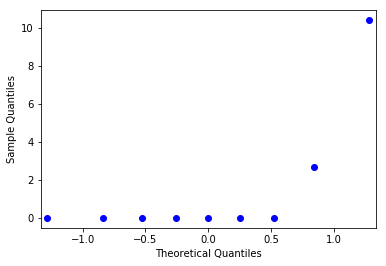

Interval: axon_layer_1 != normal


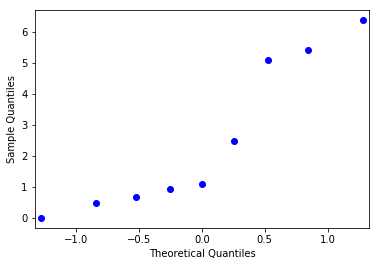

Interval: axon_layer_2 == normal


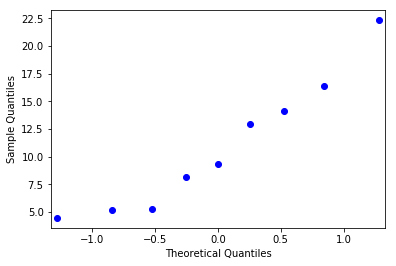

Interval: axon_layer_3 == normal


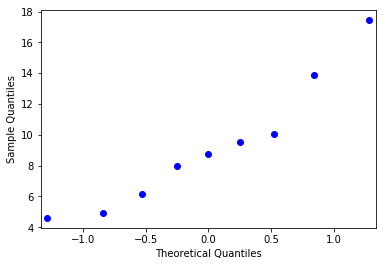

Interval: axon_layer_4 == normal
Non-normal groups -> Kruskal
KruskalResult(statistic=19.84871483505364, pvalue=0.00018244736363773635)
Rejection: kruskal
Dunn-bonferroni output               axon_layer_1  axon_layer_2  axon_layer_3  axon_layer_4
axon_layer_1      1.000000      1.000000      0.001292      0.003329
axon_layer_2      1.000000      1.000000      0.046122      0.093615
axon_layer_3      0.001292      0.046122      1.000000      1.000000
axon_layer_4      0.003329      0.093615      1.000000      1.000000


In [57]:
plot_folder = 'misc'
data_path = os.path.join(base_folder, plot_folder, 'layer_density_neuron_data.csv')

full_path = os.path.join(base_folder, plot_folder, data_path)
arr_pd = pd.read_csv(full_path, index_col=0)

print(arr_pd.head())

get_stats_multiple_groups(arr_pd, show_qq_plot=show_qq_plots, normality_test='shapiro')

# Fig S5

## Section A - rest to run

/Users/achilleasgeorgiou/Desktop/data_output/dataset_1_all/all/plots/transition_dots_rest_run/dots_amplitude-data.csv
                                 rest   running
m181129_d190111_c001_day_0   1.794823  1.848458
m2000219_d190411_c003_day_0  1.343808  1.635869
m2000219_d190411_c003_day_1  1.259689  1.288583
m2000219_d190411_c004_day_0  1.393615  1.493766
m2000219_d190411_c004_day_1  1.307464  1.397168


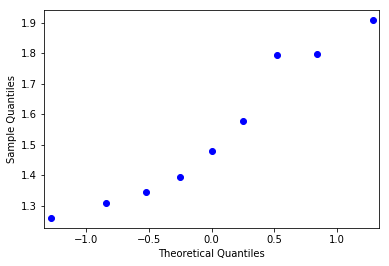

Interval: rest == normal


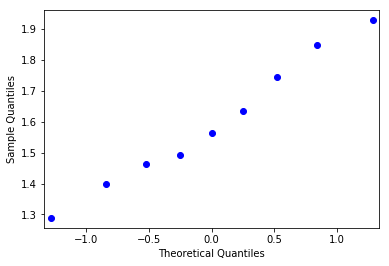

Interval: running == normal
Normality p-values [0.26540622115135193, 0.9062721729278564]
--------------------
Ttest pvalue rest running - Amplitude: ttest_pvalue 0.13789787457278835 -> not-rejected
--------------------
/Users/achilleasgeorgiou/Desktop/data_output/dataset_1_all/all/plots/transition_dots_rest_run/dots_duration-data.csv
                                 rest   running
m181129_d190111_c001_day_0   1.056171  1.081290
m2000219_d190411_c003_day_0  1.140515  1.409408
m2000219_d190411_c003_day_1  1.143096  1.113064
m2000219_d190411_c004_day_0  0.896800  1.108161
m2000219_d190411_c004_day_1  1.093096  1.218537


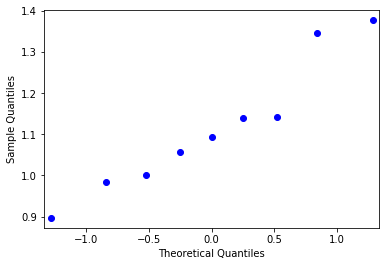

Interval: rest == normal


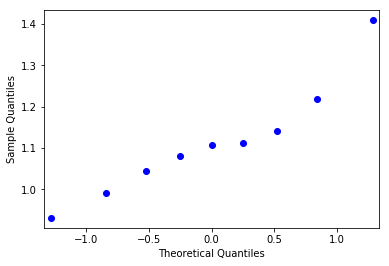

Interval: running == normal
Normality p-values [0.4645790755748749, 0.4681706130504608]
--------------------
Ttest pvalue rest running - Duration: ttest_pvalue 0.9987631988440874 -> not-rejected
--------------------
/Users/achilleasgeorgiou/Desktop/data_output/dataset_1_all/all/plots/transition_dots_rest_run/dots_Event number (per minute)-data.csv
                                   rest     running
m181129_d190111_c001_day_0   122.477732  224.470415
m2000219_d190411_c003_day_0   51.372111  280.720813
m2000219_d190411_c003_day_1   40.423839   99.622946
m2000219_d190411_c004_day_0   22.829459  163.845015
m2000219_d190411_c004_day_1   82.823944  185.570907


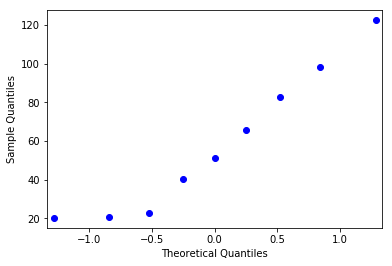

Interval: rest == normal


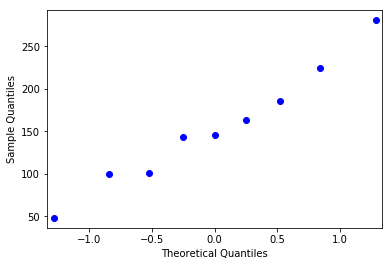

Interval: running == normal
Normality p-values [0.34575238823890686, 0.9597190618515015]
--------------------
Ttest pvalue rest running - Event number: ttest_pvalue 0.0013545542607984382 -> rejected
--------------------
/Users/achilleasgeorgiou/Desktop/data_output/dataset_1_all/all/plots/transition_dots_rest_run/dots_size-data.csv
                                 rest    running
m181129_d190111_c001_day_0   6.197367   8.353198
m2000219_d190411_c003_day_0  6.302203  10.506539
m2000219_d190411_c003_day_1  6.871263   7.516613
m2000219_d190411_c004_day_0  4.826425   8.686314
m2000219_d190411_c004_day_1  6.400439   9.763890


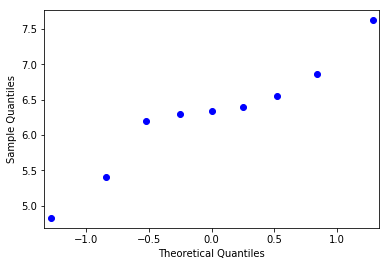

Interval: rest == normal


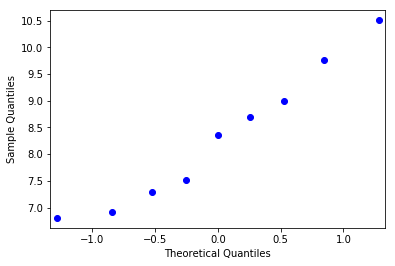

Interval: running == normal
Normality p-values [0.6281329393386841, 0.5787814259529114]
--------------------
Ttest pvalue rest running - Size: ttest_pvalue 0.0027780643127424446 -> rejected
--------------------


In [58]:
col_filt = ['rest', 'running']

plot_folder = 'dataset_1_all/all/plots'

identifiers = ['Amplitude', 'Duration', 'Event number', 'Size']
rest_run_data_paths = ["transition_dots_rest_run/dots_amplitude-data.csv",
                            "transition_dots_rest_run/dots_duration-data.csv",
                            "transition_dots_rest_run/dots_Event number (per minute)-data.csv",
                            "transition_dots_rest_run/dots_size-data.csv"]

for i, data_path in enumerate(rest_run_data_paths):
    full_path = os.path.join(base_folder, plot_folder, data_path)
    print(full_path)
    arr_pd = pd.read_csv(full_path, index_col=0)

    arr_pd = arr_pd[col_filt]
    print(arr_pd.head())

    rejected_normal_groups_np, normality_results = test_normality(arr_pd, show_qq_plot=True, normality_test='shapiro')

    print('Normality p-values', normality_results)

    #Paired two tailed ttest
    ttest_pvalue = two_tailed_ttest(arr_pd, col_filt[0], col_filt[1], is_unpaired=False)

    print('--------------------')
    print(f'Ttest pvalue {col_filt[0]} {col_filt[1]} - {identifiers[i]}: ttest_pvalue {ttest_pvalue} -> {"rejected" if ttest_pvalue < 0.05 else "not-rejected"}')
    print('--------------------')



## Section B - Rest to vibrisa exploration

/Users/achilleasgeorgiou/Desktop/data_output/dataset_1_all/all/plots/transition_dots_rest_rest_stick/dots_amplitude-data.csv
                                 rest  stick_rest
m181129_d190111_c001_day_0   1.794823    1.816852
m2000219_d190411_c003_day_0  1.343808    1.374178
m2000219_d190411_c003_day_1  1.259689    1.212675
m2000219_d190411_c004_day_0  1.393615    1.381925
m2000219_d190411_c004_day_1  1.307464    1.330125


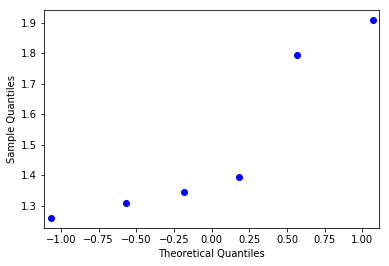

Interval: rest == normal


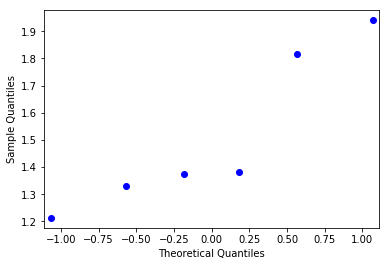

Interval: stick_rest == normal
Normality p-values [0.07377438247203827, 0.13546758890151978]
--------------------
Ttest pvalue rest stick_rest - Amplitude: ttest_pvalue 0.5509654189431648 -> not-rejected
--------------------
/Users/achilleasgeorgiou/Desktop/data_output/dataset_1_all/all/plots/transition_dots_rest_rest_stick/dots_duration-data.csv
                                 rest  stick_rest
m181129_d190111_c001_day_0   1.056171    0.821267
m2000219_d190411_c003_day_0  1.140515    1.141004
m2000219_d190411_c003_day_1  1.143096    1.103375
m2000219_d190411_c004_day_0  0.896800    0.903330
m2000219_d190411_c004_day_1  1.093096    1.081511


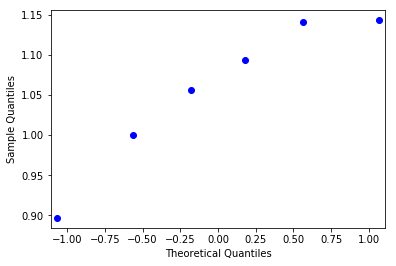

Interval: rest == normal


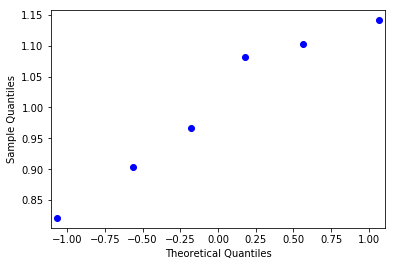

Interval: stick_rest == normal
Normality p-values [0.4147757887840271, 0.5725123286247253]
--------------------
Ttest pvalue rest stick_rest - Duration: ttest_pvalue 0.2207696970433758 -> not-rejected
--------------------
/Users/achilleasgeorgiou/Desktop/data_output/dataset_1_all/all/plots/transition_dots_rest_rest_stick/dots_Event number (per minute)-data.csv
                                   rest  stick_rest
m181129_d190111_c001_day_0   122.477732  173.943798
m2000219_d190411_c003_day_0   51.372111   59.847232
m2000219_d190411_c003_day_1   40.423839   46.928279
m2000219_d190411_c004_day_0   22.829459   25.469232
m2000219_d190411_c004_day_1   82.823944   73.676214


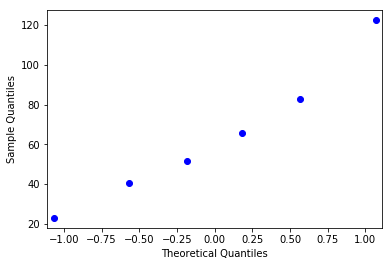

Interval: rest == normal


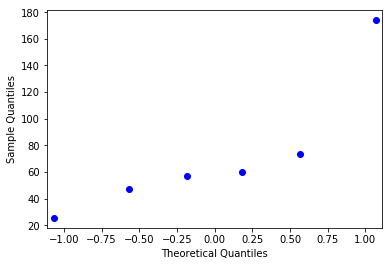

Interval: stick_rest != normal
Normality p-values [0.8490149974822998, 0.043686263263225555]
--------------------
Ttest pvalue rest stick_rest - Event number: ttest_pvalue 0.39053967966997144 -> not-rejected
--------------------
/Users/achilleasgeorgiou/Desktop/data_output/dataset_1_all/all/plots/transition_dots_rest_rest_stick/dots_size-data.csv
                                 rest  stick_rest
m181129_d190111_c001_day_0   6.197367    6.857915
m2000219_d190411_c003_day_0  6.302203    6.636193
m2000219_d190411_c003_day_1  6.871263    6.105774
m2000219_d190411_c004_day_0  4.826425    5.146491
m2000219_d190411_c004_day_1  6.400439    5.882350


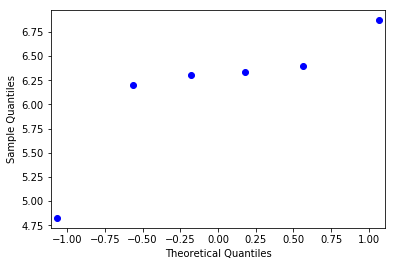

Interval: rest != normal


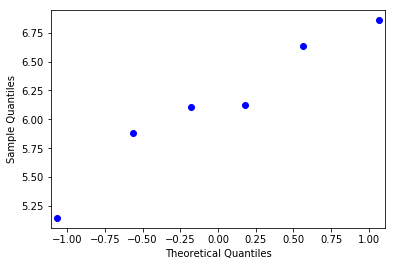

Interval: stick_rest == normal
Normality p-values [0.046942006796598434, 0.7410587668418884]
--------------------
Ttest pvalue rest stick_rest - Size: ttest_pvalue 0.8971145867100663 -> not-rejected
--------------------


In [59]:
col_filt = ['rest', 'stick_rest']

plot_folder = 'dataset_1_all/all/plots'

identifiers = ['Amplitude', 'Duration', 'Event number', 'Size']
rest_rest_stick_data_paths = ["transition_dots_rest_rest_stick/dots_amplitude-data.csv",
                            "transition_dots_rest_rest_stick/dots_duration-data.csv",
                            "transition_dots_rest_rest_stick/dots_Event number (per minute)-data.csv",
                            "transition_dots_rest_rest_stick/dots_size-data.csv"]

for i, data_path in enumerate(rest_rest_stick_data_paths):
    full_path = os.path.join(base_folder, plot_folder, data_path)
    print(full_path)
    arr_pd = pd.read_csv(full_path, index_col=0)

    arr_pd = arr_pd[col_filt]
    print(arr_pd.head())

    rejected_normal_groups_np, normality_results = test_normality(arr_pd, show_qq_plot=True, normality_test='shapiro')

    print('Normality p-values', normality_results)

    #Paired two tailed ttest
    ttest_pvalue = two_tailed_ttest(arr_pd, col_filt[0], col_filt[1], is_unpaired=False)

    print('--------------------')
    print(f'Ttest pvalue {col_filt[0]} {col_filt[1]} - {identifiers[i]}: ttest_pvalue {ttest_pvalue} -> {"rejected" if ttest_pvalue < 0.05 else "not-rejected"}')
    print('--------------------')



## Section C - Run to vibrisa stimulation

/Users/achilleasgeorgiou/Desktop/data_output/dataset_1_all/all/plots/transition_dots_run_run_stick/dots_amplitude-data.csv
                              running  stick_run_ind_15
m181129_d190111_c001_day_0   1.848458          1.891501
m2000219_d190411_c003_day_0  1.635869          1.729852
m2000219_d190411_c003_day_1  1.288583          1.262413
m2000219_d190411_c004_day_0  1.493766          1.503124
m2000219_d190411_c004_day_1  1.397168          1.392630


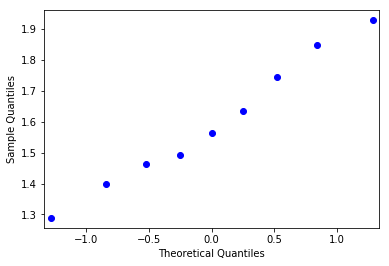

Interval: running == normal


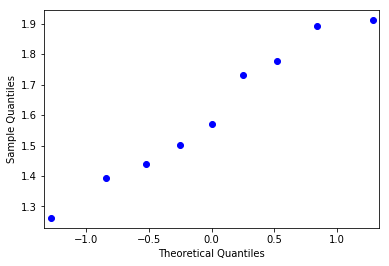

Interval: stick_run_ind_15 == normal
Normality p-values [0.9062721729278564, 0.6489120125770569]
--------------------
Ttest pvalue running stick_run_ind_15 - Amplitude: ttest_pvalue 0.36218829400332525 -> not-rejected
--------------------
/Users/achilleasgeorgiou/Desktop/data_output/dataset_1_all/all/plots/transition_dots_run_run_stick/dots_duration-data.csv
                              running  stick_run_ind_15
m181129_d190111_c001_day_0   1.081290          1.097247
m2000219_d190411_c003_day_0  1.409408          1.402719
m2000219_d190411_c003_day_1  1.113064          1.100969
m2000219_d190411_c004_day_0  1.108161          1.142847
m2000219_d190411_c004_day_1  1.218537          1.209620


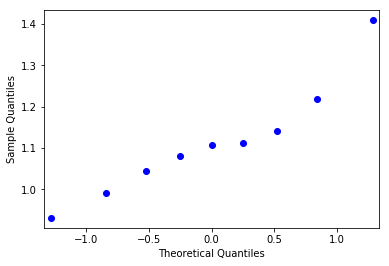

Interval: running == normal


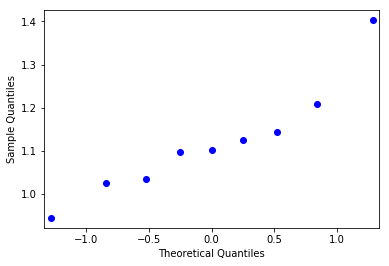

Interval: stick_run_ind_15 == normal
Normality p-values [0.4681706130504608, 0.3618677258491516]
--------------------
Ttest pvalue running stick_run_ind_15 - Duration: ttest_pvalue 0.4511388360095765 -> not-rejected
--------------------
/Users/achilleasgeorgiou/Desktop/data_output/dataset_1_all/all/plots/transition_dots_run_run_stick/dots_Event number (per minute)-data.csv
                                running  stick_run_ind_15
m181129_d190111_c001_day_0   224.470415        270.903529
m2000219_d190411_c003_day_0  280.720813        366.663588
m2000219_d190411_c003_day_1   99.622946        102.634194
m2000219_d190411_c004_day_0  163.845015        189.779370
m2000219_d190411_c004_day_1  185.570907        202.434121


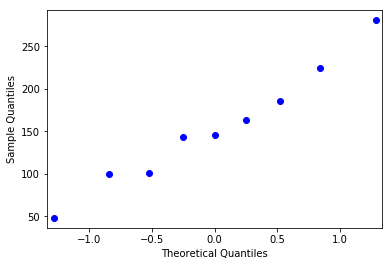

Interval: running == normal


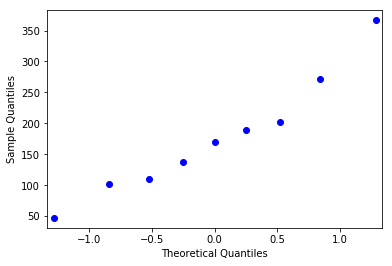

Interval: stick_run_ind_15 == normal
Normality p-values [0.9597190618515015, 0.7457038164138794]
--------------------
Ttest pvalue running stick_run_ind_15 - Event number: ttest_pvalue 0.04146889578266179 -> rejected
--------------------
/Users/achilleasgeorgiou/Desktop/data_output/dataset_1_all/all/plots/transition_dots_run_run_stick/dots_size-data.csv
                               running  stick_run_ind_15
m181129_d190111_c001_day_0    8.353198          9.612251
m2000219_d190411_c003_day_0  10.506539         12.491580
m2000219_d190411_c003_day_1   7.516613          7.888216
m2000219_d190411_c004_day_0   8.686314          9.757819
m2000219_d190411_c004_day_1   9.763890         10.540225


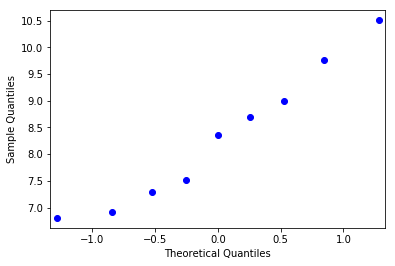

Interval: running == normal


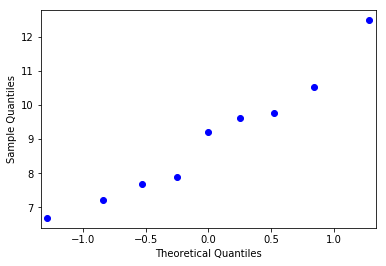

Interval: stick_run_ind_15 == normal
Normality p-values [0.5787814259529114, 0.6860499978065491]
--------------------
Ttest pvalue running stick_run_ind_15 - Size: ttest_pvalue 0.01276564326453869 -> rejected
--------------------


In [60]:
col_filt = ['running', 'stick_run_ind_15']

plot_folder = 'dataset_1_all/all/plots'

identifiers = ['Amplitude', 'Duration', 'Event number', 'Size']
run_run_stick_data_paths = ["transition_dots_run_run_stick/dots_amplitude-data.csv",
                            "transition_dots_run_run_stick/dots_duration-data.csv",
                            "transition_dots_run_run_stick/dots_Event number (per minute)-data.csv",
                            "transition_dots_run_run_stick/dots_size-data.csv"]

for i, data_path in enumerate(run_run_stick_data_paths):
    full_path = os.path.join(base_folder, plot_folder, data_path)
    print(full_path)
    arr_pd = pd.read_csv(full_path, index_col=0)

    arr_pd = arr_pd[col_filt]
    print(arr_pd.head())

    rejected_normal_groups_np, normality_results = test_normality(arr_pd, show_qq_plot=True, normality_test='shapiro')

    print('Normality p-values', normality_results)

    #Paired two tailed ttest
    ttest_pvalue = two_tailed_ttest(arr_pd, col_filt[0], col_filt[1], is_unpaired=False)

    print('--------------------')
    print(f'Ttest pvalue {col_filt[0]} {col_filt[1]} - {identifiers[i]}: ttest_pvalue {ttest_pvalue} -> {"rejected" if ttest_pvalue < 0.05 else "not-rejected"}')
    print('--------------------')


# Figure S7

## (Section B)

In [61]:
def repeated_measures_anova_S7(arr_pd, show_qq_plot=False, normality_test='kolmogorov'):
    rejected_normal_groups_np, kstest_result = test_normality(arr_pd, show_qq_plot=show_qq_plot, normality_test=normality_test)

    arr_pd["astro_id"] = arr_pd.index + 1
    arr_pd = pd.melt(arr_pd, var_name='interval', value_name='value', id_vars=['astro_id'])
    
    print(pg.rm_anova(data=arr_pd, dv='value', within='interval', subject='astro_id', detailed=True))

    post_hocs = pg.pairwise_ttests(dv='value', within='interval', subject='astro_id', data=arr_pd)
    print('Post hocs \n', post_hocs)

plot_folder = 'single_multi_stick'

data_paths = ['plots/bar_comparison/area-data.csv', 
             'plots/bar_comparison/count-data.csv', 
             'plots/bar_comparison/dffMax2-data.csv', 
             'plots/bar_comparison/time_s-data.csv'
             ]

for i, data_path in enumerate(data_paths):
    full_path = os.path.join(base_folder, plot_folder, data_path)
    print(full_path)
    arr_pd = pd.read_csv(full_path, index_col=0)

    repeated_measures_anova_S7(arr_pd, show_qq_plot=False, normality_test='shapiro')
    

/Users/achilleasgeorgiou/Desktop/data_output/single_multi_stick/plots/bar_comparison/area-data.csv
Interval: running == normal
Interval: single == normal
Interval: multi != normal
     Source        SS  DF        MS         F     p-unc     np2       eps
0  interval  0.250781   2  0.125390  8.646306  0.006604  0.6336  0.838032
1     Error  0.145022  10  0.014502       NaN       NaN     NaN       NaN
Post hocs 
    Contrast        A        B  Paired  Parametric         T  dof alternative  \
0  interval    multi  running    True        True  3.463137  5.0   two-sided   
1  interval    multi   single    True        True  3.491265  5.0   two-sided   
2  interval  running   single    True        True  1.369704  5.0   two-sided   

      p-unc   BF10    hedges  
0  0.017982  4.444  0.823452  
1  0.017447  4.545  1.183787  
2  0.229089  0.724  0.449870  
/Users/achilleasgeorgiou/Desktop/data_output/single_multi_stick/plots/bar_comparison/count-data.csv
Interval: running == normal
Interval: sin

# Figure S9

## (Section B)

/Users/achilleasgeorgiou/Desktop/data_output/dataset_1_all/all/plots/split_correlation_all/splits-data-old-random.csv


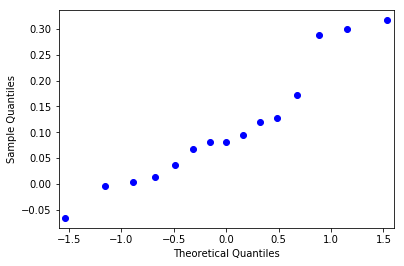

Interval: Random == normal


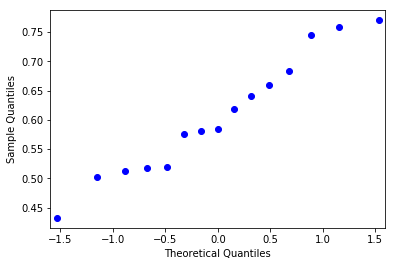

Interval: Self splits == normal


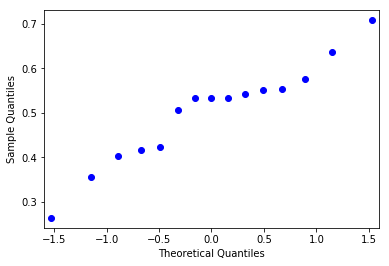

Interval: Rest-Run splits == normal


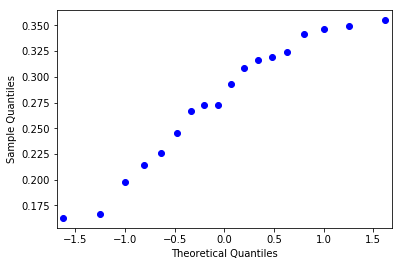

Interval: Day 0-1 Splits == normal
All normal groups -> Anova
F_onewayResult(statistic=77.76548622203293, pvalue=1.7538669888357134e-20)
Rejection: anova
Tukey output          Multiple Comparison of Means - Tukey HSD, FWER=0.05          
     group1          group2     meandiff p-adj   lower   upper  reject
----------------------------------------------------------------------
 Day 0-1 Splits          Random  -0.1676  0.001 -0.2591 -0.0762   True
 Day 0-1 Splits Rest-Run splits   0.2256  0.001  0.1342  0.3171   True
 Day 0-1 Splits     Self splits   0.3304  0.001   0.239  0.4219   True
         Random Rest-Run splits   0.3933  0.001  0.2978  0.4888   True
         Random     Self splits    0.498  0.001  0.4025  0.5936   True
Rest-Run splits     Self splits   0.1048 0.0262  0.0093  0.2003   True
----------------------------------------------------------------------


In [62]:
plot_folder = 'dataset_1_all/all/plots'
#Using the exact .csv file used in figure paper
data_path = 'split_correlation_all/splits-data-old-random.csv'

full_path = os.path.join(base_folder, plot_folder, data_path)
print(full_path)

arr_pd = pd.read_csv(full_path, index_col=0)
arr_pd.head()

get_stats_multiple_groups(arr_pd, show_qq_plot=True, normality_test='shapiro')



